# Определение региона для добычи

#### Тема проекта:
- Выбор наиболее прибыльного региона для добычи полезных ископаемых

#### Цель:
- Из нескольких регионов определить регион с максимальной прибылью и минимальным риском убытка

#### Поставленные задачи:
- Исследовать предоставленные данные;
- Использовать модель линейной регрессии для обучения;
- Оценить средний запас сырья, рассчитать значения RMSE для каждого региона;
- Рассчитать потенциальную прибыль для каждого региона;
- Техникой Bootstrap определить риск убытков для каждого региона.

#### Краткий план работы:
- [Шаг 1. Загрузка и подготовка данных](#Шаг-1.-Загрузка-и-подготовка-данных)
  - [1.1. Открытие файлов](#1.1.-Открытие-файлов)
  - [1.2. Изучение данных](#1.2.-Изучение-данных)
  - [1.3. Подготовка данных для обучения](#1.3.-Подготовка-данных-для-обучения)
- [Шаг 2. Обучение и проверка модели](#Шаг-2.-Обучение-и-проверка-модели)
- [Шаг 3. Расчёт прибыли и рисков](#Шаг-3.-Расчёт-прибыли-и-рисков)
  - [3.1. Расчёт прибыли](#3.1.-Расчёт-прибыли)
  - [3.2. Оценка рисков](#3.2.-Оценка-рисков)
  
#### Вывод:
- Для каждого региона рассчитан средний запас сырья и значение RMSE;
- Для каждого региона проведена оценка потенциальной прибыли и риска убытка;
- Выбран регион с максимальной потенциальной прибылью и минимальным риском убытка.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *scipy*, *sklearn*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Шаг 1. Загрузка и подготовка данных

Этот шаг разобьем на несколько этапов:  

- [**1.1. Открытие файлов**](#1.1.-Открытие-файлов). Выгрузим данные и изучим содержимое. Проведём проверку на наличие **пропусков** и **дубликатов**.
- [**1.2. Изучение данных**](#1.2.-Изучение-данных). Рассмотрим распределение имеющихся данных по регионам.
- [**1.3. Подготовка данных для обучения**](#1.3.-Подготовка-данных-для-обучения). Выделим **признаки** и **целевой признак** по каждому региону.

### 1.1. Открытие файлов

Для начала **ознакомимся** с полученными данными по 3 регионам. Проверим их на наличие **пропусков** и **дубликатов**.  
Согласно условию, в файлах содержатся **синтетические данные** (для сохранения конфиденциальности информации).  
Содержание файлов должно быть следующим:
- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек (характеристики проб нефти);
- *product* — объём запасов в скважине (тыс. баррелей).

In [2]:
def read_info_open(file_path):    
    """Функция возвращает датафрейм и выводит наименования колонок, количество дубликатов, общую информацию:
    - file_path- путь к файлу .csv."""
    
    new_df_name = pd.read_csv(file_path)

    # проверка на дубликаты
    print('Количество дубликатов строк:', new_df_name.duplicated().sum())
    print('Количество дубликатов id:', new_df_name['id'].duplicated().sum())
    print()
    
    # общая информация
    print(new_df_name.info())
    
    # вывод первых строк
    return new_df_name

### 1. Выгрузка файла geo_data_0

In [3]:
# выгрузка, вывод первых строк
geo_0 = read_info_open('datasets/geo_data_0.csv')
geo_0.head()

Количество дубликатов строк: 0
Количество дубликатов id: 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


- Файл содержит **100000 строк** и **5 колонок** (характеристики проб нефти и её количество).
- **Пропуски** отсутствуют.
- **Задублированных** строк нет, однако встречается **10 дубликатов** в колонке *id* (уникальный идентификатор скважины).

Для одного id в одном регионе присутствуют **разные значения** по признакам. Это кажется не совсем корректным. Для обучения модели нам **не понадобились бы id**, но в реальной жизни следовало бы спросить у коллег, почему в одном регионе повторяются уникальные **id** с разными характеристиками. 

### 2. Выгрузка файла geo_data_1

In [4]:
# выгрузка, вывод первых строк
geo_1 = read_info_open('datasets/geo_data_1.csv')
geo_1.head()

Количество дубликатов строк: 0
Количество дубликатов id: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


- Файл содержит **100000 строк** и **5 колонок** (характеристики проб нефти и её количество).
- **Пропуски** отсутствуют.
- **Задублированных** строк нет, однако встречается **4 дубликата** в колонке *id* (уникальный идентификатор скважины).

И снова для **одинаковых id** встречаются строки с **разными характеристиками**.

### 3. Выгрузка файла geo_data_2

In [5]:
# выгрузка, вывод первых строк
geo_2 = read_info_open('datasets/geo_data_2.csv')
geo_2.head()

Количество дубликатов строк: 0
Количество дубликатов id: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


- Файл содержит **100000 строк** и **5 колонок** (характеристики проб нефти и её количество).
- **Пропуски** отсутствуют.
- **Задублированных** строк нет, однако в этом регионе также встречается **4 дубликата** в колонке *id* (уникальный идентификатор скважины).

### Вывод 1.1.
- Во всех трёх файлах **100000 строк** (данные по 100000 скважинам) и **5 колонок** (характеристики проб нефти и её количество).
- В файлах **отсутствуют пропуски**.
- Во всех файлах нет дубликатов по строкам, но встречается незначительное количество **дубликатов** в колонке с **уникальными id**: регион 1 - 10 дуликатов, регион 2 и 3 - по 4 дубликата. Хотя колонка id и **не будет использоваться** при обучении модели, в реальной жизни об этом следовало бы сообщить коллегам.

### 1.2. Изучение данных

Для каждой скважины указаны **объемы запасов в скважине** и **три признака f0, f1, f2**. Известно, что данные **синтетические**.  
Мы не можем проверить признаки на **правдоподобность** значений. Однако мы можем посмотреть **распределение** признаков по регионам.  

Создадим **общую таблицу** со всеми регионами и напишем **функции**, которые помогут нам для выведения нужной информации.

In [6]:
# создание вспомогательной колонки с регионом
geo_0['region'] = 'reg_0'
geo_1['region'] = 'reg_1'
geo_2['region'] = 'reg_2'

# общий файл со всеми показателями
geo_total = geo_0.append(geo_1).append(geo_2)
print(geo_total.info())
geo_total.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 16.0+ MB
None


,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,reg_0
1,2acmU,1.334711,-0.340164,4.365080,73.037750,reg_0
2,409Wp,1.022732,0.151990,1.419926,85.265647,reg_0
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,reg_0
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,reg_0


Напишем функцию, которая будет **строить боксплоты** и выводить **сводную статистику** для данных, в которых нужно изучить распределение:

In [7]:
def boxplot_and_sumstat(df_name, col_name, group_by, box_yticks=None):
    """Функция возвращает боксплот и сводную статистику по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит разбивка по группам;
    - box_yticks (необязательный параметр) - задать диапазон для оси y."""
    
    boxplot = df_name.boxplot(col_name, by=group_by, figsize=(7, 6))
    plt.title(f'Сравнение регионов по признаку {col_name}')
    plt.xlabel('Регионы \n (reg_0 - регион 1; reg_1 - регион 2; reg_2 - регион 3)')
    plt.ylabel(f'Значение признака {col_name}')
    plt.yticks(box_yticks)
    plt.show()
    
    sumstat = df_name.groupby(group_by)[col_name].describe()
    return sumstat

Напишем функцию для построения **гистограмм на одном графике**:

In [8]:
def hist_by_groups(df_name, col_name, group_by, hist_xticks=None, n_bins=30):    
    """Функция возвращает три гистограммы по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит разбивка по группам;
    - hist_xticks (необязательный параметр) - задать диапазон для оси x;
    - n_bins - количество корзин для гистограмм."""
    
    # настройка размера
    plt.figure(figsize=(9,5))
    
    # построение гистограммы
    # на одном графике построим распределение данных
    
    col_list = ['blue', 'orange', 'green']
    for i in range(3):
        
        # построение гистограммы
        sns.distplot(df_name[df_name[group_by] == f'reg_{i}'][col_name], kde=True, label=f'регион {i+1}', bins=n_bins)
        
        # линии среднего значения   
        plt.axvline(x=df_name[df_name[group_by] == f'reg_{i}'][col_name].mean(), color=col_list[i],
                    linestyle='--', label=f'регион {i+1} (среднее)')

    plt.title(f'Распределение по регионам, признак {col_name}')
    plt.xlabel(f'Значение признака {col_name}')
    plt.xticks(hist_xticks, rotation=45)

    plt.legend()
    plt.grid()
    plt.show()

В некоторых случаях сопоставление гистограмм на одном графике может быть не очень наглядно. Поэтому пропишем функцию, которая будет выводить **гистограммы на отдельных графиках**.

In [9]:
def one_hist(df_name, col_name, color_name, reg_label, hist_xticks=None, n_bins=30):  
    """Функция возвращает гистограмму по колонке.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - color_name - цвет графика;
    - reg_label - указать название региона в именительном падеже;
    - hist_xticks (необязательный параметр) - задать диапазон для оси x;
    - n_bins - количество корзин для гистограммы."""
    
    sns.distplot(df_name[col_name], color=color_name, label=reg_label, bins=n_bins, kde=True)
    plt.axvline(x=df_name[col_name].mean(), color=color_name, linestyle='--', label=reg_label+' (среднее)')
        
    plt.title(f'Распределение признакa {col_name} ' + reg_label)
    plt.xlabel(f'Значение признака {col_name}')
    plt.xticks(hist_xticks, rotation=45)

    plt.legend()
    plt.grid()
    plt.show()

### 1. Признак f0

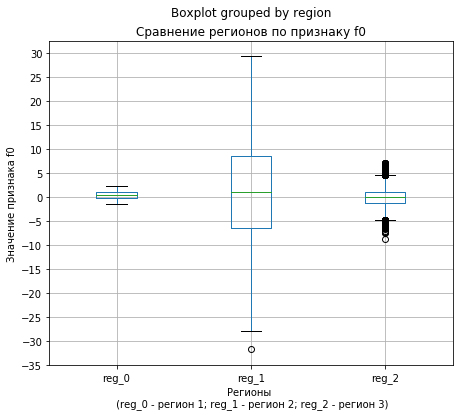

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
reg_0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
reg_1,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
reg_2,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262


In [10]:
# построение боксплот и сводной статистики
boxplot_and_sumstat(geo_total, 'f0', 'region', [i*5 for i in range(-7, 7)])

- В выборочных данных наиболее **широкий диапазон** признака *f0* наблюдается **во втором региона (reg_1)**. Этому же региону принадлежат самые выдающиеся значения по **минимуму** и **максимуму**.  
- Для **региона 3** наблюдаются "хвосты "**выбросов** как в большую, так и в меньшую сторону.  
- У **региона 1** наименьшее варьирование признака *f0*, по сравнению с другими регионами.

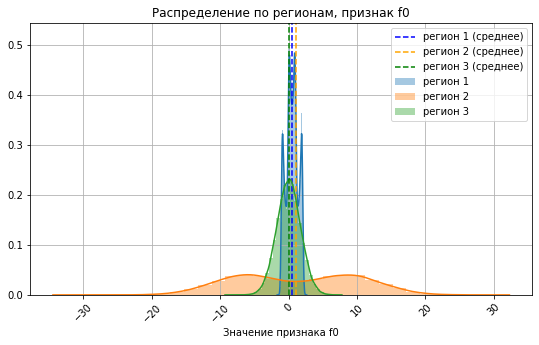

In [11]:
# построение совместной гистограммы
hist_by_groups(geo_total, 'f0', 'region')

Поскольку у **второго региона** самое **широкое** варьирование признака, сопоставление всех регионов на одной гистограмме не очень наглядно.  
Выведем **гистограммы** по регионам на **отдельных графиках**.

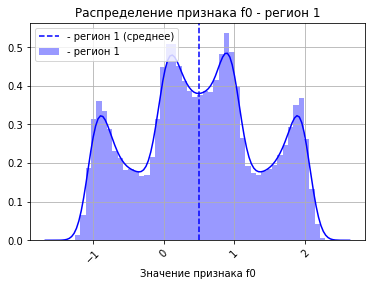

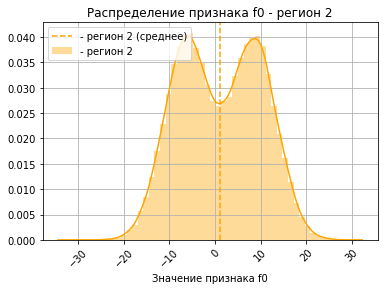

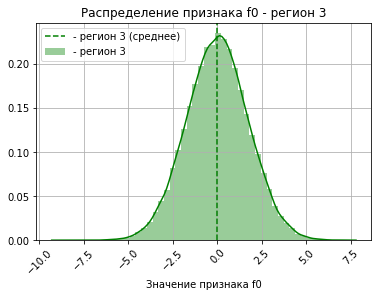

In [12]:
# цикл для гистограмм
geo_list = [geo_0, geo_1, geo_2]
col_list = ['blue', 'orange', 'green']
for i in range(len(geo_list)):
    one_hist(geo_list[i], 'f0', col_list[i], f'- регион {i+1}', n_bins=50)

- Больше всего на **нормальное** похоже распределение признака *f0* в **регионе 3**.  
- В **регионах 1 и 2** наблюдается **несколько ярко выраженных пиков**. Значит, в выборке по этим регионам может быть скрыто ещё несколько "подвыборок". В обоих регионах **среднее** делит выборку на практически две зеркальные половины.

### 2. Признак f1

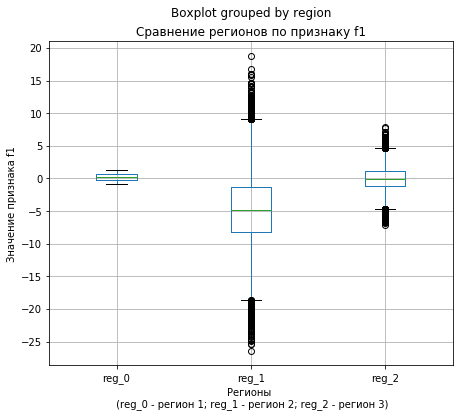

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
reg_0,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
reg_1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
reg_2,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801


In [13]:
# построение боксплот и сводной статистики
boxplot_and_sumstat(geo_total, 'f1', 'region', [i*5 for i in range(-5, 5)])

- Снова по **второму региону** наблюдается **самое широкое** варьирование признака (теперь признака *f1*). Но также стоит отметить, что **выборочное среднее** располагается **ниже**, чем для 1 и 2 региона.  
- Для **региона 3** так же наблюдаются "хвосты "**выбросов** как в большую, так и в меньшую сторону.  
- У **региона 1** наименьшее варьирование признака *f1*, по сравнению с другими регионами.

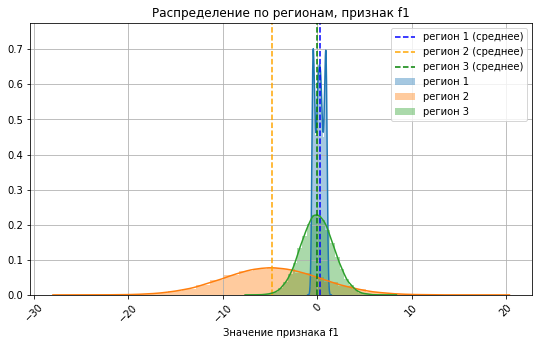

In [14]:
# построение совместной гистограммы
hist_by_groups(geo_total, 'f1', 'region')

Из-за **широкого** распределения для **второго региона** совместная картина не очень наглядна.  
Выведем **гистограммы** по регионам на **отдельных графиках**.

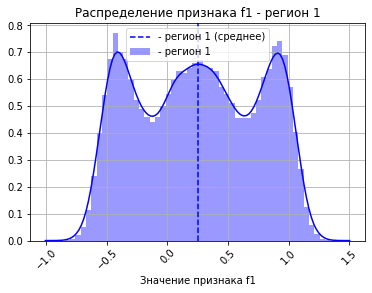

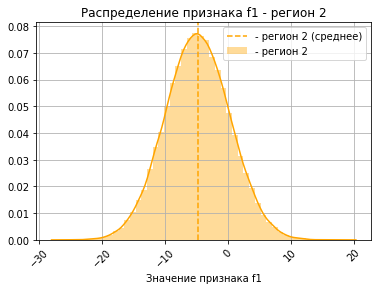

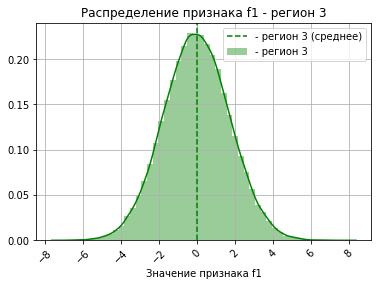

In [15]:
# цикл для гистограмм
geo_list = [geo_0, geo_1, geo_2]
col_list = ['blue', 'orange', 'green']
for i in range(len(geo_list)):
    one_hist(geo_list[i], 'f1', col_list[i], f'- регион {i+1}', n_bins=50)

- Для признака *f1* **нормальное распределение** наблюдается у **регионов 2 и 3**.
- В **регионе 1** так же есть ощущение "спрятанных подвыборок" с **выборочным средним**, делящим данные на две зеркальные части.

### 3. Признак f2

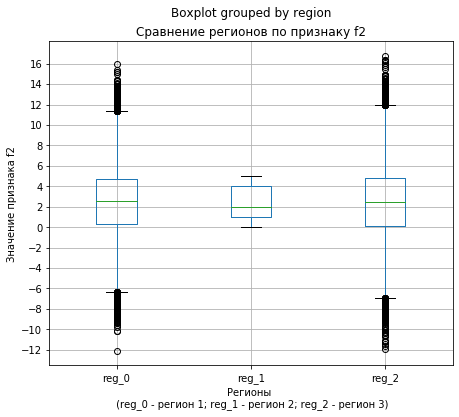

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
reg_0,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
reg_1,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
reg_2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402


In [16]:
# построение боксплот и сводной статистики
boxplot_and_sumstat(geo_total, 'f2', 'region', [i*2 for i in range(-6, 9)])

- **Выборочные средние** по всем трем регионам достаточно **похожи**.
- Здесь также выделяется **второй регион**, но на этот раз по нему **самое узкое** распределение признака *f2*.
- Распределение для **региона 1 и 3** выглядят достаточно **похоже**: **квартили** располагаются примерно **на одном уровне**, есть хвост **выбросов**.

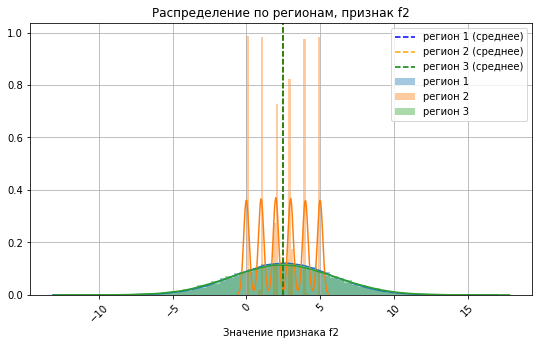

In [17]:
# построение совместной гистограммы
hist_by_groups(geo_total, 'f2', 'region')

- **Регионы 1 и 3** практически накладываются друг на друга.
- При этому у **региона 2** весьма необычное зигзагообразное распределение.  

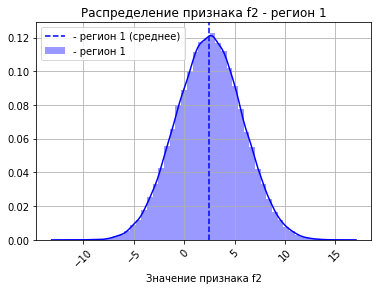

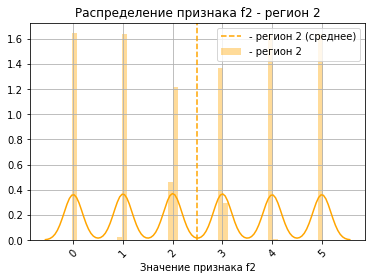

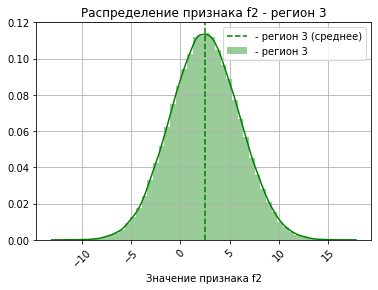

In [18]:
# цикл для гистограмм
geo_list = [geo_0, geo_1, geo_2]
col_list = ['blue', 'orange', 'green']
for i in range(len(geo_list)):
    one_hist(geo_list[i], 'f2', col_list[i], f'- регион {i+1}', n_bins=50)

- Для признака *f2* **нормальное распределение** наблюдается у **регионов 1 и 3**. Выборочные распределения настолько похожи, что на общей гистограмме практически накладывались друг на друга.
- В **регионе 2** распределение данных очень необычное - значения концентрируются около целых чисел (0, 1, 2, 3, 4, 5), в результате чего распределение выглядит зигзагообразным.

### 4. Целевой признак (объём запасов в скважине)

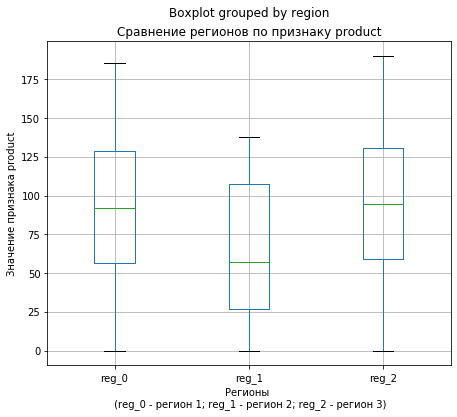

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
reg_0,100000.0,92.500,44.288691,0.0,56.497507,91.849972,128.564089,185.364347
reg_1,100000.0,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408
reg_2,100000.0,95.000,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


In [19]:
# построение боксплот и сводной статистики
boxplot_and_sumstat(geo_total, 'product', 'region')

- **Выборочные средние** значения похожи для **региона 1 и 3**.
- На первый взгляд выборочное среднее **2-го региона**, а также соответствующие квартили, располагаются **ниже**, чем у остальных регионов.

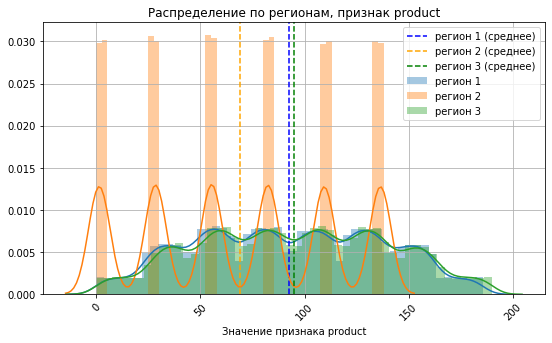

In [20]:
# построение совместной гистограммы
hist_by_groups(geo_total, 'product', 'region', n_bins = 50)

- Снова распределения **регионов 1 и 3** имеют похожую форму и практически накладываются друг на друга.  
- Распределение **региона 2** имеет зигзанообразную форму.

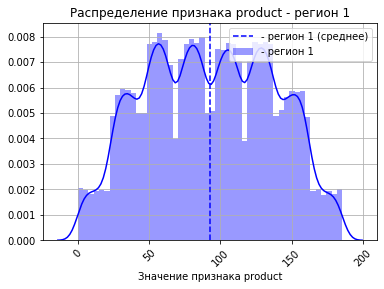

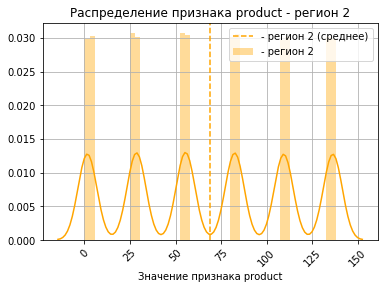

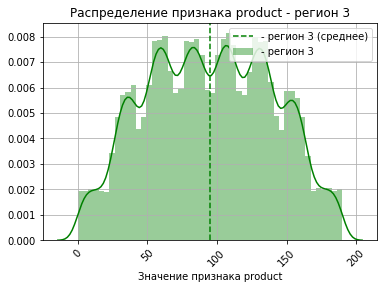

In [21]:
# цикл для гистограмм
geo_list = [geo_0, geo_1, geo_2]
col_list = ['blue', 'orange', 'green']
for i in range(len(geo_list)):
    one_hist(geo_list[i], 'product', col_list[i], f'- регион {i+1}', n_bins=50)

- **Нельзя сказать**, что в каком-либо из регионов наблюдается **нормальное распределение** по целевому признаку *product*.
- Все распределения имеют **несколько ярко выраженных пиков**. 

### 5. Матрица корреляций

Дополнительно можно построить **матрицу корреляций**, чтобы понимать, как соотносятся выборочные данные для разных регионов.

In [22]:
def corr_matrix_plot(geo_name, reg_num):
    """Функция возвращает визуализацию и таблицу корреляций:
    - geo_name - наименование датафрейма;
    - reg_num - номер региона."""
    
    # визуализация матрицы корреляций
    _ = pd.plotting.scatter_matrix(geo_name, figsize=[8, 8], alpha=0.01)
    plt.suptitle(f'Визуализация матрицы корреляций, регион {reg_num}')
    plt.show()
    
    # матрица с корреляциями, регион 1
    return geo_name.corr()

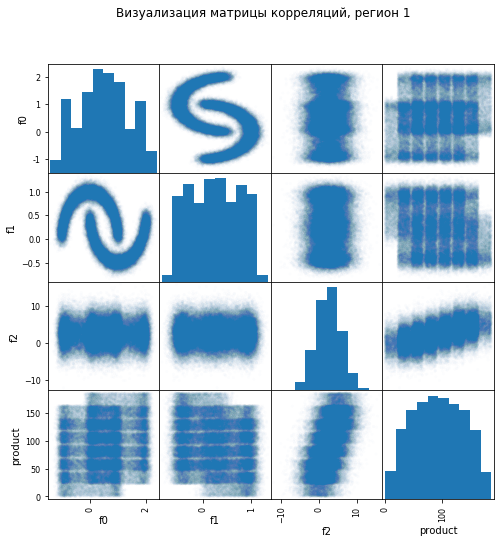

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [23]:
# регион 1
corr_matrix_plot(geo_0, 1)

- На первый взгляд **линейная положительная** взаимосвязь прослеживается между признаком *f2* и *product (объём запасов)*. 
- Несмотря на довольно высокий показатель корреляции между признаком *f0* и *f1*, взаимосвязь явно не линейная.

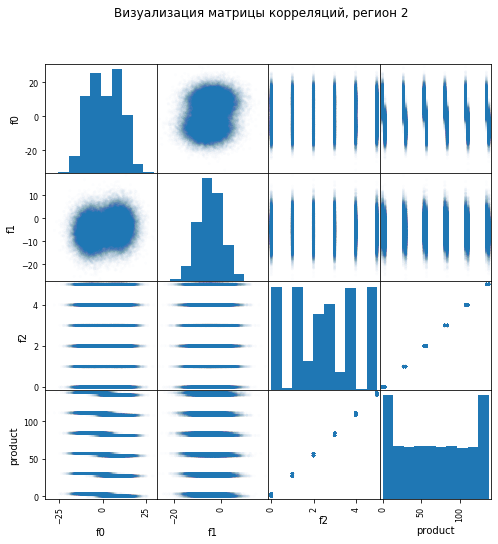

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [24]:
# регион 2
corr_matrix_plot(geo_1, 2)

- Для **региона 2** на первый взгляд также прослеживается **положительная** взаимосвязь между признаком *f2* и *product (объём запасов)*.
- Но связь не совсем правильно назвать **линейной**, потому что на графике заметно выделяется несколько **"точек концентрации" значений**.

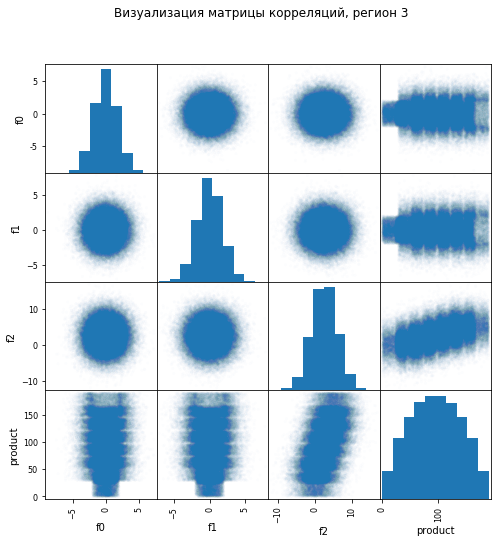

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [25]:
# регион 3
corr_matrix_plot(geo_2, 3)

- Для **региона 3** также прослеживается линейная положительная взаимосвязь между признаком *f2* и *product (объём запасов)*.

### Вывод 1.2.

Были рассмотрены *признаки (f0, f1, f2)* и *целевой признак (product)* по регионам:
- **Признак f0**
 - Самое широкое варьирование признака наблюдается в **регионе 2**.
 - На **нормальное** похоже выборочное распределение **региона 3**.
 - В **регионах 1 и 2** есть **несколько ярко выраженных пиков**.


- **Признак f1**
 - Самый широкий диапазон признака также характерен для **региона 2**.
 - Для **региона 2 и 3** характерно **нормальное** распределение данных.
 - В **регионе 1** наблюдается **несколько ярко выраженных пиков**.
 
 
- **Признак f2**
 - В отличие от предыдущих случаев, **регион 2** имеет **наименьший** диапазон данных.
 - Выборочное распределение **1 и 3 региона** практически **идентично** и похоже на **нормальное**.
 - **Регион 2** имеет зигзагообразное распределение, где данные концентрируются около целых значений (0, 1, 2, 3, 4, 5).
 
 
- **Целевой признак product (объём запасов)**
 - Выборочные данные **не распределены нормально** для **всех трёх регионов**. Во всех случаях отсутствует унимодальность и наблюдается несколько пиков.
 - Для **региона 2** также характерно зигзагообразное распределение с концентрацией данных около определенных значений.
 
 
- **Изучение корреляции признаков**
 - При сравнении переменных между собой, для всех трёх регионов проислеживается **положительная взаимосвязь** между признаком **f2 и product (объём запасов)**.

### 1.3. Подготовка данных для обучения

Для дальнейшей работы выделим **признаки** и **целевой признак** в наших данных для каждого региона.  
Колонка *id* не потребуется для обучения.
- **Целевой признак** - это переменная *product* (объём запасов в скважине).
- **Признаки** - это признаки *f0, f1, f2*.

In [26]:
# РЕГИОН 1 (geo_0)
# выделение целевого признака
target_g0 = geo_0['product']
# выделение признаков
features_g0 = geo_0.drop(['id', 'product', 'region'], axis=1)

# РЕГИОН 2 (geo_1)
# выделение целевого признака
target_g1 = geo_1['product']
# выделение признаков
features_g1 = geo_1.drop(['id', 'product', 'region'], axis=1)

# РЕГИОН 3 (geo_2)
# выделение целевого признака
target_g2 = geo_2['product']
# выделение признаков
features_g2 = geo_2.drop(['id', 'product', 'region'], axis=1)

# вывод нескольких строк для примера
features_g2.head()

,f0,f1,f2
0,-1.146987,0.963328,-0.828965
1,0.262778,0.269839,-2.530187
2,0.194587,0.289035,-5.586433
3,2.236060,-0.553760,0.930038
4,-0.515993,1.716266,5.899011


### Вывод 1.3.
- Для каждого региона были выделены **признаки (f0, f1, f2)** и **целевой признак (product)**. 

## Шаг 1. Вывод

Мы ознакомились с полученными данными, разбив шаг на три этапа:
- **1.1. Открытие файлов**
 - Во всех файлах присутствует **по 100000 строк** (данные по 100000 скважинам), **отсутствуют пропуски**, но встречаются **дубликаты** в уникальных id.

    
- **1.2. Изучение данных**
 - В некотрых случаях выборочное распределение признака в регионе может **отличаться от нормального** и иметь **несколько ярко выраженных пиков**.
 - При рассмотрении корреляции, на первый взгляд для **всех трёх регионов** прослеживается **положительная взаимосвязь** между **признаком f2 и product (объём запасов)**.

    
- **1.3. Подготовка данных для обучения**
 - Для каждого региона были выделены **признаки (f0, f1, f2)** и **целевой признак (product)**.

## Шаг 2. Обучение и проверка модели

Объединим все этапы в одной функции. Функция принимает **на вход признаки** и **целевой признак** региона. Далее она делит выборку на **обучающую и валидационную** в соотношении **75:25**, **обучает** модель, а также рассчитывает необходимые значения:
- **верные варианты** для валидационной выборки
- **предсказания** для валидационной выборки
- значение **rmse**

In [27]:
def model_split_train_rmse(features, target, random_state):
    """Функция возвращает массив с предсказанными значениями, среднее значение предсказаний, mse, rmse:
    - features - выделенные признаки региона;
    - target - выделенный целевой признак региона;
    - random_state - значение random_state."""
    
    # разделение выборки на обучающую и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=random_state)
    
    # обучение модели, вывод предсказанных валидационных значений
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
       
    # вычисление RMSE
    mse_geo = mean_squared_error(target_valid, predictions_valid)
    rmse_geo = mse_geo ** 0.5
    
    # приведем оба массива к виду Series с порядковыми индексами, начиная с 0
    target_valid = pd.Series(target_valid.values)
    predictions_valid = pd.Series(predictions_valid)
    
    return (target_valid, predictions_valid, mse_geo, rmse_geo)

Применим функцию к выделенным **признакам** и **целевым признакам регионов**:

In [28]:
SEED = 54321

# применение функции для 3 регионов
target_valid_g0, predictions_valid_g0, mse_g0, rmse_g0 = model_split_train_rmse(features_g0, target_g0, SEED)
target_valid_g1, predictions_valid_g1, mse_g1, rmse_g1 = model_split_train_rmse(features_g1, target_g1, SEED)
target_valid_g2, predictions_valid_g2, mse_g2, rmse_g2 = model_split_train_rmse(features_g2, target_g2, SEED)


# cредний запас реального сырья
geo_list = [geo_0, geo_1, geo_2]
for i in range(len(geo_list)):
    print(f'Средний запас реального сырья на скважину (регион {i+1}):', end=' ')
    print('{:.2F}'.format(geo_list[i]['product'].mean()))

print()

# cредний запас предсказанного сырья
predictions_valid_list = [predictions_valid_g0, predictions_valid_g1, predictions_valid_g2]
for i in range(len(predictions_valid_list)):
    print(f'Средний запас предсказанного сырья на скважину (регион {i+1}):', end=' ')
    print('{:.2F}'.format(predictions_valid_list[i].mean()))

print()    

# значения RMSE
rmse_list = [rmse_g0, rmse_g1, rmse_g2]
for i in range(len(rmse_list)):
    print(f'Средний RMSE (регион {i+1}):', end=' ')
    print('{:.2F}'.format(rmse_list[i].mean()))

Средний запас реального сырья на скважину (регион 1): 92.50
Средний запас реального сырья на скважину (регион 2): 68.83
Средний запас реального сырья на скважину (регион 3): 95.00

Средний запас предсказанного сырья на скважину (регион 1): 92.16
Средний запас предсказанного сырья на скважину (регион 2): 68.45
Средний запас предсказанного сырья на скважину (регион 3): 94.92

Средний RMSE (регион 1): 37.68
Средний RMSE (регион 2): 0.89
Средний RMSE (регион 3): 40.15


Имеет смысл проверить нашу модель, сравнив RMSE для **константной модели** - для каждого объекта будет спрогнозировано **среднее значение** целевого признака.

In [29]:
# шаблон для таблицы
check_mse_rmse = pd.DataFrame({
    'stat_name': ['rmse_linreg', 'rmse_mean'],
    'reg_0': ['-', '-'],
    'reg_1': ['-', '-'],
    'reg_2': ['-', '-']
})
check_mse_rmse.set_index('stat_name', inplace=True)

# заполнение значений для модели
for i in range(len(rmse_list)):
    check_mse_rmse.loc['rmse_linreg'][f'reg_{i}'] = rmse_list[i]
    
# расчёт значений для константной модели
target_valid_list = [target_valid_g0, target_valid_g1, target_valid_g2]
for i in range(len(target_valid_list)):
    predicted_valid_mean = pd.Series(target_valid_list[i].mean(), index=target_valid_list[i].index)
    rmse_mean = mean_squared_error(target_valid_list[i], predicted_valid_mean) ** 0.5 
    check_mse_rmse.loc['rmse_mean'][f'reg_{i}'] = rmse_mean

check_mse_rmse

,reg_0,reg_1,reg_2
stat_name,,,
rmse_linreg,37.6834,0.892282,40.1525
rmse_mean,44.2202,45.9086,44.9559


- Для **региона 1 и 3** значения модели с константной довольно **близки**. Тем не менее, с помощью модели мы смогли **улучшить показатель**.
- Для **региона 2** модель существенно **снизила значение RMSE**. Значит, модель даёт наименьшую погрешность результатов для **региона 2**.

## Шаг 2. Вывод

- Выборки для всех трёх регионов были разбиты на **обучающую** и **валидационную** в пропорции 75:25.
- Было проведено сравнение модели с **константной**, где в качестве константы было выбрано реальное среднее по региону.
- По всем регионам **RMSE нашей модели ниже**, что говорит о том, что модель отработала **лучше константной**.
- Для каждого региона рассчитаны необходимые показатели:
 - **Средние** значения предсказанного сырья на скважину по регионам:
   - **Регион 1** - 92.16 тыс. баррелей,
   - **Регион 2** - 68.45 тыс. баррелей,
   - **Регион 3** - 94.92 тыс. баррелей.
  
 - Значения **RMSE** модели:
   - **RMSE региона 1** - 37.68 тыс. баррелей, 
   - **RMSE региона 2** - 0.89 тыс. баррелей, 
   - **RMSE региона 3** - 40.15 тыс. баррелей.

## Шаг 3. Расчёт прибыли и рисков 

Данный шаг разделим на следующие этапы:
- [**3.1. Расчёт прибыли**](#3.1.-Расчёт-прибыли). Напишем функцию для расчёта прибыли. Оценим прибыль при помощи процедуры *Bootstrap*.
- [**3.2. Оценка рисков**](#3.2.-Оценка-рисков). Оценим риски, использовав результаты процедуры *Bootstrap*.

### 3.1. Расчёт прибыли

Сохраним в переменных ключевые показатели, связанные с **финансовой** стороной вопроса:
- Бюджет на разработку скважин в регионе — **10 млрд рублей**.
- Один баррель сырья приносит **450 рублей дохода**.
- Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.

In [30]:
# бюджет на разработку скважин в регионе
RUB_GEO_BDG = 10**10

# доход от одного барреля сырья
RUB_PER_BBL = 450

# доход от одной единицы (тысяча баррелей сырья)
RUB_K_PER_BBL = 450 * 1000

**"Безубыточная разработка"** - значит, скважины региона должны принести **минимум 10 млрд рублей**. В противном случае, не будет покрыт даже бюджет на разработку и мы получим **отрицательные**, т е. **убыточные** значения.  
Согласно условию, для разработки выбирается **200 самых прибыльных скважин**. Посмотрим, какой минимум должен приходиться на скважину региона, чтобы считать добычу **безубыточной**, т. е. покрывающей хотя бы **10 млрд рублей**.

In [31]:
print("Суммарное количество единиц сырья на регион: {:.2f}".format(RUB_GEO_BDG / RUB_K_PER_BBL))
print('Единиц сырья на скважину: {:.2f}'.format(RUB_GEO_BDG / RUB_K_PER_BBL / 200))

Суммарное количество единиц сырья на регион: 22222.22
Единиц сырья на скважину: 111.11


Значит, **111.11 единиц сырья (тыс. баррелей)** - это пограничное значение. Для сравнения выведем ещё раз **средний запас** в каждом регионе:

In [32]:
# cредний запас предсказанного сырья 
print('Средний запас предсказанного сырья на скважину (регион 1): {:.2F}'.format(predictions_valid_g0.mean()))
print('Средний запас предсказанного сырья на скважину (регион 2): {:.2F}'.format(predictions_valid_g1.mean()))
print('Средний запас предсказанного сырья на скважину (регион 3): {:.2F}'.format(predictions_valid_g2.mean()))

Средний запас предсказанного сырья на скважину (регион 1): 92.16
Средний запас предсказанного сырья на скважину (регион 2): 68.45
Средний запас предсказанного сырья на скважину (регион 3): 94.92


На первый взгляд все средние значения на скважину **ниже пограничного**. Однако ранее мы уже исследовали распределение объема скважин по регионам и знаем, что что могут встречаться как скважины **с гораздо большим**, так и **с гораздо меньшим объемом**. 

Для наглядности выведем ещё раз график и сводную статистику:

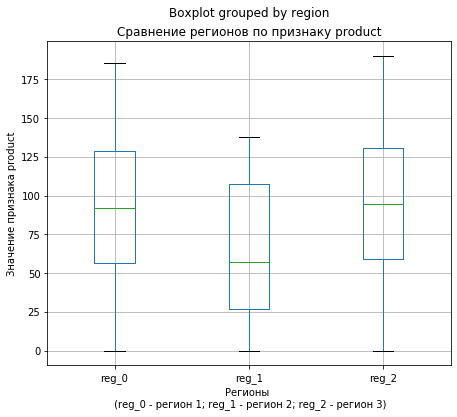

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
reg_0,100000.0,92.500,44.288691,0.0,56.497507,91.849972,128.564089,185.364347
reg_1,100000.0,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408
reg_2,100000.0,95.000,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


In [33]:
# построение боксплот и сводной статистики
boxplot_and_sumstat(geo_total, 'product', 'region')

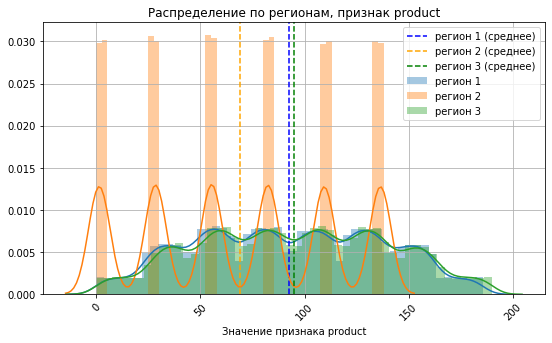

In [34]:
# построение совместной гистограммы
hist_by_groups(geo_total, 'product', 'region', n_bins = 50)

Есть вероятность того, что в исследуемые **500 точек** попадут **200 точек**, которые смогут скомпенсировать друг друга и в итоге давать **среднее** по региону **больше, чем 111.11 единиц**. Чтобы проверить это, нужно просимулировать процесс выбора скважин и рассчитать возможную **прибыль** и **риски убытка**. Этому процессу будет посвящён следующий шаг.

Необходимо написать **функцию**, которая рассчитывала бы **прибыль по топ-200 скважинам** для каждого региона.   
Сначала вручную проделаем все шаги для топ-200 скважин из валидационных выборок, а затем уже реализуем их в функции.

 
Посмотрим, какие результаты получатся, если мы возьмём из предсказаний **топ-200 скважин** и рассчитаем, сколько потенциально можно заработать с них. Для этого **умножим объем сырья скважины** на **стоимость единицы (450 тыс руб.)** - так мы получим узнаем оборот. Затем вычтем затраты на разработку - **10 млрд руб.** 

In [35]:
# выделение топ-200 скважин с наибольшим 
top_200_g0 = predictions_valid_g0.sort_values(ascending=False)[:200]
top_200_g1 = predictions_valid_g1.sort_values(ascending=False)[:200]
top_200_g2 = predictions_valid_g2.sort_values(ascending=False)[:200]

# проверка нескольких значений
print('Регион 1:', top_200_g0.values[:10])
print('Регион 2:',top_200_g1.values[:10])
print('Регион 3:',top_200_g2.values[:10])
print()

# суммарное количество единиц на 200 скважин
print('Регион 1: {:.2f} единиц (тыс. баррелей)'.format(top_200_g0.sum()))
print('Регион 2: {:.2f} единиц (тыс. баррелей)'.format(top_200_g1.sum()))
print('Регион 3: {:.2f} единиц (тыс. баррелей)'.format(top_200_g2.sum()))

Регион 1: [176.1876505  175.99424111 175.77914709 173.22366028 171.95263526
 169.15288429 169.07927986 168.13528893 166.86015031 166.81661303]
Регион 2: [139.52594855 139.52385386 139.51160096 139.50803497 139.43489184
 139.37976006 139.37196916 139.30500152 139.2644573  139.25706217]
Регион 3: [176.1508555  174.12000566 173.52063341 172.5026236  171.25683309
 165.74347972 165.25706531 163.72613257 163.38189773 161.95549587]

Регион 1: 30958.18 единиц (тыс. баррелей)
Регион 2: 27736.47 единиц (тыс. баррелей)
Регион 3: 29710.90 единиц (тыс. баррелей)


Теперь рассчитаем, сколько можно **заработать** с этих 200 скважин, с учётом **вычета бюджета 10 млрд руб.**:

In [36]:
# расчёт оборота с 200 скважин (в рублях)
rub_revenue_g0 = top_200_g0.sum() * RUB_K_PER_BBL
rub_revenue_g1 = top_200_g1.sum() * RUB_K_PER_BBL
rub_revenue_g2 = top_200_g2.sum() * RUB_K_PER_BBL

# расчёт прибыли с 200 скважин с вычетом расходов на разработку (10 млрд)
rub_profit_g0 = rub_revenue_g0 - RUB_GEO_BDG
rub_profit_g1 = rub_revenue_g1 - RUB_GEO_BDG
rub_profit_g2 = rub_revenue_g2 - RUB_GEO_BDG

print('Регион 1: {:.3f} млн рублей'.format(rub_profit_g0 / 10**6))
print('Регион 2: {:.3f} млн рублей'.format(rub_profit_g1 / 10**6))
print('Регион 3: {:.3f} млн рублей'.format(rub_profit_g2 / 10**6))

Регион 1: 3931.182 млн рублей
Регион 2: 2481.412 млн рублей
Регион 3: 3369.903 млн рублей


Значения получились очень внушительные, но стоит помнить, что мы брали **топ-200** из всех предсказанных значений, т. е. из 25000 скважин. На деле мы сможем исследовать только **500 скважин** и отобрать уже из них 200. Поэтому, скорее всего, результаты будут скромнее.

#### Функция для расчёта прибыли

Рассмотрев принцип отбора, напишем **функцию**, которая в полученной выборке выделить **топ-200 скважин**.  
Наверху продублируем глобальные переменные, которые понадобятся для работы функции.

Функция будет принимать на вход **реальные** и **предсказанные** значения целевого признака.  
Затем будет отбираться **топ-200 значений** из **предсказанных**. Чтобы проверить, **реальную прибыль**, мы выбираем соответствующие **реальные** значения и делаем по ним расчёты.

Ранее (на этапе разделения выборок, в функции **model_split_train_rmse**) уже учтён нюанс, что некоторые значения могут быть представлены в виде **Series**, а некоторые в виде **array**. Мы привели **актуальные и предсказанные** значения к типу **Series** с порядковой индексацией, начиная с 0. Для расчёта реальной прибыли сопоставим соответствующие **индексы предсказанных** значений **реальным**.

In [37]:
# глобальные переменные
RUB_GEO_BDG = 10**10 # бюджет на разработку скважин в регионе
RUB_K_PER_BBL = 450 * 1000 # доход от одной единицы (тысяча баррелей сырья)

def profit_rub_mln(target_oil_well, predictions_oil_well):    
    """Функция выделяет топ-200 и вычисляет прибыль / убыток (млн руб.).
    - target_oil_well - реальные значения целевого признака;
    - predictions_oil_well - предсказанные значения целевого признака."""
      
    # сортировка ПРЕДСКАЗАННЫХ значений по убыванию
    top_200_predicted = predictions_oil_well.sort_values(ascending=False)[:200]
       
    # выбор значений с теми же индексами из РЕАЛЬНЫХ значений
    # ограничение до 200 значений
    top_200_target = target_oil_well[top_200_predicted.index]
    
    # вычисление прибыли / убытка с учётом 10 млрд на разработку
    rub_profit = top_200_target.sum() * RUB_K_PER_BBL - RUB_GEO_BDG
    
    # возвращение результата в млн руб.
    return rub_profit / 10**6

Проверим работу функции на ранее рассчитанных данных:

In [38]:
print('Регион 1: {:.3f} млн рублей'.format(profit_rub_mln(target_valid_g0, predictions_valid_g0)))
print('Регион 2: {:.3f} млн рублей'.format(profit_rub_mln(target_valid_g1, predictions_valid_g1)))
print('Регион 3: {:.3f} млн рублей'.format(profit_rub_mln(target_valid_g2, predictions_valid_g2)))

Регион 1: 3178.632 млн рублей
Регион 2: 2415.087 млн рублей
Регион 3: 2413.786 млн рублей


- Из-за существующих расхождений **предсказанных** значений с **реальными**, мы получили **более низкую прибыль** по всем трём регионам.
- Поскольку в **регионе 2** самый низкий показатель **RMSE**, **различия** между реальными и предсказанными значениями прибыли **менее существенны**, чем для остальных регионов.

In [39]:
predict_subsample = predictions_valid_g0.sample(n=500, replace=True, random_state=12345)
target_subsample = target_valid_g0[predict_subsample.index]

# проверка - сравнение индексов подвыборок
assert((predict_subsample.index == target_subsample.index).all())

# сброс индексов 
predict_subsample.reset_index(drop=True, inplace=True)
target_subsample.reset_index(drop=True, inplace=True)

top_200_predicted = predict_subsample.sort_values(ascending=False)[:200]
top_200_target = target_subsample[top_200_predicted.index]

# проверка - сравнение топ-200
assert((top_200_predicted.index == top_200_target.index).all())

top_200_target

276    162.153488
389    146.261727
213    155.298222
130    156.869788
396    144.607600
          ...    
117    146.031402
127     73.363740
373    160.288497
421    112.119413
484     89.351515
Length: 200, dtype: float64

#### Функции для процедуры Bootstrap

Напишем функции для проведения процедуры Bootstrap:
- Функция для расчёта **значения прибыли** при проведении нескольких экспериментов.
- Функция для построения **гистограммы** распределения прибыли.

In [40]:
def profit_distrib_list(target_oil_well, predictions_oil_well, random_seed, n_sample=1000, n_oil_well=500):   
    """Функция возвращает значения распределения прибыли для заданного количества экспериментов: 
    - target_oil_well - реальные значения целевого признака;
    - predictions_oil_well - предсказанные значения целевого признака;
    - random_seed - значение для RandomState;
    - n_sample (по умолчанию 1000) - количество извлекаемых выборок;
    - n_oil_well (по умолчанию 500)- количество исследуемых точек."""
    
    state = np.random.RandomState(random_seed)
    # будущий лист с распределением доходов
    result = []
    
    for i in range(n_sample):
        
        # выбираем 500 случайных точек из предсказаний
        predict_subsample = predictions_oil_well.sample(n=n_oil_well, replace=True, random_state=state)
        # выбираем эти же точки из реальных значений
        target_subsample = target_oil_well[predict_subsample.index]
        
        # проверка - сравнение индексов подвыборок
        assert((predict_subsample.index == target_subsample.index).all())
        
        # сброс индексов 
        predict_subsample.reset_index(drop=True, inplace=True)
        target_subsample.reset_index(drop=True, inplace=True)
        
        # вычисление прибыли
        top200_profit = profit_rub_mln(target_subsample, predict_subsample)
        
        # добавляем результат в лист с доходами
        result.append(top200_profit)
        
    return result

# тестирование функции
test = profit_distrib_list(target_valid_g0, predictions_valid_g0, SEED)
print(len(test))
print(test[:10])

1000
[417.73064020313643, 193.8741214053955, 216.79036864165306, -19.1859805449543, 227.25697949310876, 471.7727309457645, 174.36415364901544, 262.1146326760883, 156.6629096086731, 469.4135617060337]


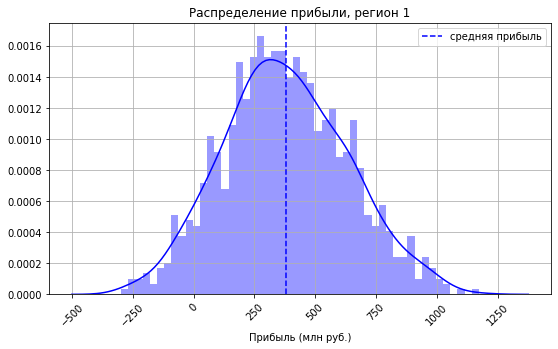

In [41]:
def profit_distrib_hist(profit_list, color_name, n_bins, hist_title, hist_xticks=None):   
    """Функция возвращает гистограмму распределения прибыли:
    - profit_list - массив со значениями прибыли;
    - hist_color - цвет гистограммы и линий
    - n_bins - количество корзин;
    - hist_title - указать номер региона, например 'Регион 1';
    - hist_xticks - (необязательный параметр) - задать диапазон для оси x."""
    
    # настройка размера
    plt.figure(figsize=(9,5))
    
    # построение гистограммы
    sns.distplot(profit_list, color=color_name, bins=n_bins, kde=True) 
    # построение средней линии
    plt.axvline(x=np.mean(profit_list), linestyle='--', color=color_name, label='средняя прибыль')
    
    plt.title('Распределение прибыли, ' + hist_title)
    plt.xlabel('Прибыль (млн руб.)')
    plt.xticks(hist_xticks, rotation=45)
    
    plt.legend()
    plt.grid()
    plt.show()
    
# тестирование функции
profit_distrib_hist(test, 'blue', 50, 'регион 1')

#### Оценка распределения прибыли

Применим написанные функции для всех трёх регионов и посмотрим на результаты:

In [42]:
# проверка значений прибыли
profit_list_g0 = profit_distrib_list(target_valid_g0, predictions_valid_g0, SEED) # регион 1
profit_list_g1 = profit_distrib_list(target_valid_g1, predictions_valid_g1, SEED) # регион 2
profit_list_g2 = profit_distrib_list(target_valid_g2, predictions_valid_g2, SEED) # регион 3
profit_list = [profit_list_g0, profit_list_g1, profit_list_g2]

for i in range(len(profit_list)):
    print(f'Количество выборок (регион {i+1}):', len(profit_list[i]))
    print(f'Среднее по выборке (регион {i+1}):', np.mean(profit_list[i]))
    print(f'Первые несколько элементов (регион {i+1}):', profit_list[i][:10])
    print()

Количество выборок (регион 1): 1000
Среднее по выборке (регион 1): 378.3811785126006
Первые несколько элементов (регион 1): [417.73064020313643, 193.8741214053955, 216.79036864165306, -19.1859805449543, 227.25697949310876, 471.7727309457645, 174.36415364901544, 262.1146326760883, 156.6629096086731, 469.4135617060337]

Количество выборок (регион 2): 1000
Среднее по выборке (регион 2): 411.37648220969794
Первые несколько элементов (регион 2): [354.28182476542094, 379.97035585624883, 444.90698166454314, 131.66862192261695, 760.1979359004077, 430.60102004010963, 538.3311310554028, 173.77790896496964, 289.3451989571247, -46.720499550741195]

Количество выборок (регион 3): 1000
Среднее по выборке (регион 3): 396.8250083029139
Первые несколько элементов (регион 3): [396.5452010838795, 764.7615242046013, 593.7421947660293, 463.69767967170145, 264.29542834906005, 578.9134187636242, 377.628615826643, -47.33584738141632, 641.4136951955128, 267.561831238636]



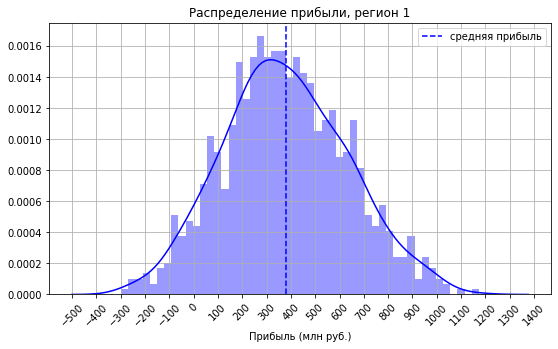

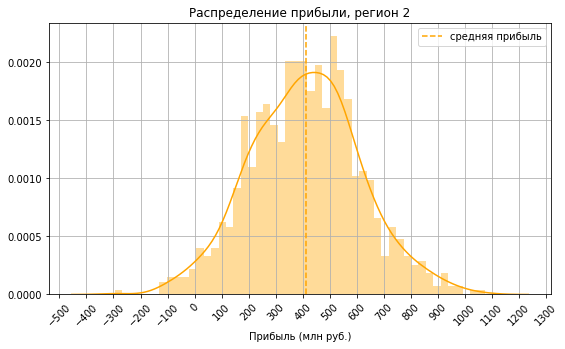

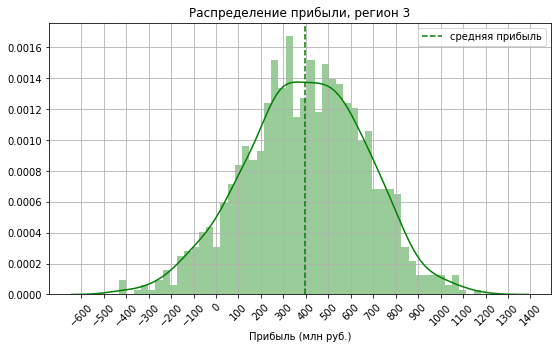

In [43]:
# гистограммы распределения прибыли
profit_distrib_hist(profit_list_g0, 'blue', 50, 'регион 1', [i*100 for i in range(-5, 15)])
profit_distrib_hist(profit_list_g1, 'orange', 50, 'регион 2', [i*100 for i in range(-5, 14)])
profit_distrib_hist(profit_list_g2, 'green', 50, 'регион 3', [i*100 for i in range(-6, 15)])

Итак, мы рассчитали **прибыль** и **выборочное среднее** по каждому региону, построили **гистограммы распределения**.   
Во всех регионах **прибыль** распределена **нормально** - распределение уномодально (пик в районе среднего) и симметрично.  

Получив **выборочные средние**, оценим **95% доверительный интервал** для каждого среднего региона. Доверительный интервал позволяет оценить интервал, где может располагаться **реальное значение среднего**, т. е. значение генеральной совокупности.

In [44]:
profit_series_g0 = pd.Series(profit_list_g0) # регион 1
profit_series_g1 = pd.Series(profit_list_g1) # регион 2
profit_series_g2 = pd.Series(profit_list_g2) # регион 3
profit_series_list = [profit_series_g0, profit_series_g1, profit_series_g2]

# значения доверительных интервалов
confidence_interval_list = []

for i in range(len(profit_series_list)):
    print(f'Регион {i+1}')
    print("Среднее:", profit_series_list[i].mean())
    confidence_interval = st.t.interval(0.95, len(profit_series_list[i])-1,
                                           profit_series_list[i].mean(), profit_series_list[i].sem())
    print("95%-ый доверительный интервал:", confidence_interval)
    confidence_interval_list.append(confidence_interval)
    print()

Регион 1
Среднее: 378.38117851260085
95%-ый доверительный интервал: (362.5731320469218, 394.1892249782799)

Регион 2
Среднее: 411.3764822096977
95%-ый доверительный интервал: (398.7555791367044, 423.997385282691)

Регион 3
Среднее: 396.82500830291355
95%-ый доверительный интервал: (380.2633620638362, 413.3866545419909)



Средние оценки прибыли по регионам:  
1. **Регион 2** занимает 1 место с результатом **411.37 млн рублей**, 95% доверительный интервал от **398 до 423 млн руб.**  
2. **Регион 3** занимает 2 место с результатом **396.82 млн рублей**, 95% доверительный интервал от **380 до 413 млн руб.**  
3. **Регион 1** занимает 3 место с результатом **378.38 млн рублей**, 95% доверительный интервал от **362 до 394 млн руб.**

### 3.2. Оценка рисков

Существует риск того, что мы выберем не самые богатые для добычи скважины. Поэтому следует **оценить риски**, просимулировав процесс выбора скважин и рассчитав потенциальную прибыль.

Также нам следует оценить **убытки** - т. е. вероятность того, что мы получим **отрицательную прибыль**.  
Здесь мы также можем воспользоваться результатами техники Bootstrap.

Мы несколько раз провели эксперимент и построили **распределение размера прибыли** по каждому региону.  
Мы можем оценить, какая доля из полученных результатов **меньше нуля**.

In [45]:
# регион 1
loss_rate_g0 = np.sum(profit_series_g0 < 0) / len(profit_series_g0)
print('Вероятность убытка (регион 1): {:.2%}'.format(loss_rate_g0))

# регион 2
loss_rate_g1 = np.sum(profit_series_g1 < 0) / len(profit_series_g1)
print('Вероятность убытка (регион 2): {:.2%}'.format(loss_rate_g1))

# регион 3
loss_rate_g2 = np.sum(profit_series_g2 < 0) / len(profit_series_g2)
print('Вероятность убытка (регион 3): {:.2%}'.format(loss_rate_g2))

Вероятность убытка (регион 1): 6.80%
Вероятность убытка (регион 2): 2.10%
Вероятность убытка (регион 3): 7.60%


Сведём в таблицу **средние** оценки по прибыли и вероятность **убытка**:

In [46]:
region_mining = pd.DataFrame({
    'measurement': ['mean_profit_mln_rub', 'confidence_interval_lower', 'confidence_interval_upper', 'loss_rate_pcnt'],
    'region_0': [profit_series_g0.mean(), confidence_interval_list[0][0], confidence_interval_list[0][1], loss_rate_g0 * 100],
    'region_1': [profit_series_g1.mean(), confidence_interval_list[1][0], confidence_interval_list[1][1], loss_rate_g1 * 100],
    'region_2': [profit_series_g2.mean(), confidence_interval_list[2][0], confidence_interval_list[2][1], loss_rate_g2 * 100]
})

region_mining.set_index('measurement', inplace=True)
region_mining

,region_0,region_1,region_2
measurement,,,
mean_profit_mln_rub,378.381179,411.376482,396.825008
confidence_interval_lower,362.573132,398.755579,380.263362
confidence_interval_upper,394.189225,423.997385,413.386655
loss_rate_pcnt,6.800000,2.100000,7.600000


- По **Региону 2** **самая высокая средняя прибыль** - около **411.37 млн руб.** Ещё одним преимуществом является **самый низкий риск убытка** среди всех регионов - **около 2.1%**.
- **Регион 3** занимает второе место по средней прибыли - около **396.82 млн руб.** Однако, в этом регионе **самый высокий риск убытка** - **около 7.6%**.
- **Региона 1** имеет **самый низкий** показатель **по средней прибыли** - около **378.38 млн руб.** По рискам убытка регион располагается на 2 месте - **около 6.8%**.
    
Можно порекомендовать **добычу во 2 регионе**. Этот регион имеет **самые высокие** показатели по **средней прибыли** и **самые низкие** показатели **по риску**, что делает его наиболее оптимальным регионом для разработки.

Тем не менее, в реальной жизни перед разработкой следует оценить и **другие факторы**, связанные не только с самой нефтью, но и с ланшафтом, инфраструктурой, экологией региона и др. Например, залежи могут быть большими, но сам процесс добычи очень трудоёмкий. Либо добыча может повлечь за собой необратимые экологические последствия.

## Шаг 3. Вывод
    
Данный шаг был разбит на несколько этапов:
- **3.1. Расчёт прибыли**
 - На валидационной выборке каждого региона мы отобрали **топ-200 скважин** и рассчитали, какой **доход** они принесут.
 - Была написана **функция**, которая отбирает **топ-200 скважин** из выборки и рассчитывает по ним прибыль.
 - С помощью процедуры Bootstrap:
   - Построено **распределение возможной прибыли** скважин для каждого региона.
   - Найдено **среднее значение** прибыли.
   - Для среднего значения оценён **доверительный интервал**.
 - Были получены следующие **средние оценки прибыли** по регионам:        
   - **1 место - регион 2**, среднее 411.37 млн рублей, 95% доверительный интервал от 398 до 423 млн руб. 
   - **2 место - регион 3**, среднее 396.82 млн рублей, 95% доверительный интервал от 380 до 413 млн руб.
   - **3 место - регион 1**, среднее 378.38 млн рублей, 95% доверительный интервал от 362 до 394 млн руб. 

- **3.2. Оценка рисков**
 - По результатам Bootstrap оценена вероятность **убытка**, т. е. **доля прибыли меньше 0**:  
   - **1 место - регион 2**, вероятность убытка 2.1%
   - **2 место - регион 1**, вероятность убытка 6.8%
   - **3 место - регион 3**, вероятность убытка 7.6%
    
Можно порекомендовать **добычу во 2 регионе**. Этот регион имеет **самые высокие** показатели по **средней прибыли** и **самые низкие** показатели **по риску**, что делает его наиболее оптимальным регионом для разработки.

# Итоговый вывод
    
## Шаг 1. Загрузка и подготовка данных
 - В нашем распоряжении данные по **3 регионам**. В каждом файле содержалось **10000 строк**, отсутствовали пропуски, но встречались **дубликаты** в уникальных *id*.
 - Были изучены распределения **признаков** данных для каждого региона. В некоторых случаях распределение признака было **нормальным**, а в некоторых - имело **несколько ярко выраженных пиков**. 
 - При первом ознакомлении сильнее всего **целевой признак (product)** коррелировал с **признаком f2**.
 - Для каждого региона были выделены **признаки (f0, f1, f2)** и **целевой признак (product)**.
    
    
## Шаг 2. Обучение и проверка модели
 - Было проведено выделение **обучающей** и **валидационной** выборок в пропорциях 75:25.
 - Проведено **обучение модели**, модель обучения - **линейная регрессия**.
 - Рассчитан **средний** запас предсказанного сырья и **RMSE** модели.
 - Проведено сравнение модели с **константной** моделью (в качестве константы выбрано среднее по региону).
 - По всем регионам **RMSE нашей модели ниже**, что говорит о том, что модель отработала **лучше константной**.

    
## Шаг 3. Расчёт прибыли и рисков 
 - Для **финансовых расчётов** созданы переменные. **RUB_GEO_BDG** (бюджет в 10 млрд руб.), **RUB_PER_BBL** (доход от одного барреля сырья), **RUB_K_PER_BBL** (доход от одной единицы сырья (тыс. баррелей)).   
 - Для наглядности выведены **средние значения скважин** по регионам: **регион 1 - 92.16 ед., регион 2 - 68.45 ед., регион 3 - 94.92 ед**.  
 - Рассмотрено **пограничное значение** при возможности разработки 200 скважин - скважина должна давать **не менее 111.11 единиц сырья**. Но поскольку скважины могут давать как значительно больше, так и значительно меньше этого среднего, на следующих этапах был просимулирован процесс выбора скважин.
    
- При расчёте **прибыли** были получены следующие оценки по регионам:      
  - **1 место - регион 2**, среднее 411.37 млн рублей, 95% доверительный интервал от 398 до 423 млн руб. 
  - **2 место - регион 3**, среднее 396.82 млн рублей, 95% доверительный интервал от 380 до 413 млн руб.
  - **3 место - регион 1**, среднее 378.38 млн рублей, 95% доверительный интервал от 362 до 394 млн руб.    
        
- Оценена вероятность **убытка**:  
  - **1 место - регион 2**, вероятность убытка 2.1%
  - **2 место - регион 1**, вероятность убытка 6.8%
  - **3 место - регион 3**, вероятность убытка 7.6%


- Можно порекомендовать **добычу во 2 регионе**. Этот регион имеет **самые высокие** показатели по **средней прибыли** и **самые низкие** показатели **по риску**, что делает его наиболее оптимальным регионом для разработки.
- Тем не менее, в реальной жизни перед разработкой следует оценить и **другие факторы**, связанные с ланшафтом, инфраструктурой, экологией региона и др., и уже исходя из всех факторов принимать решение.